# Food101 Classification

**Task:**<br>Food 101 is a labelled data set with 101 different food classes. Each food class contains 1000 images. Using the data provided, a Machine Learning Model that can classify 101 classes in Food 101 dataset is created.

In [ ]:
import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import tensorflow as tf
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from tensorflow.keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K

import os

In [ ]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.0



#### Get the paths of the images and the train-test image files for each category

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "content/drive/MyDrive/food-101/food-101/images",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE )
food = dataset.class_names
food

Found 101000 files belonging to 101 classes.


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
len(dataset)

3157

In [ ]:
# find file paths
print('Number of images per class:\n')
for i in food:
  globals()["f_" + str(i)] = glob.glob('content/drive/MyDrive/food-101/food-101/images/'+i+'/*')
  print('{}:\t{}'
      .format(str(i),len(globals()["f_" + str(i)])))


Number of images per class:

apple_pie:	1000
baby_back_ribs:	1000
baklava:	1000
beef_carpaccio:	1000
beef_tartare:	1000
beet_salad:	1000
beignets:	1000
bibimbap:	1000
bread_pudding:	1000
breakfast_burrito:	1000
bruschetta:	1000
caesar_salad:	1000
cannoli:	1000
caprese_salad:	1000
carrot_cake:	1000
ceviche:	1000
cheese_plate:	1000
cheesecake:	1000
chicken_curry:	1000
chicken_quesadilla:	1000
chicken_wings:	1000
chocolate_cake:	1000
chocolate_mousse:	1000
churros:	1000
clam_chowder:	1000
club_sandwich:	1000
crab_cakes:	1000
creme_brulee:	1000
croque_madame:	1000
cup_cakes:	1000
deviled_eggs:	1000
donuts:	1000
dumplings:	1000
edamame:	1000
eggs_benedict:	1000
escargots:	1000
falafel:	1000
filet_mignon:	1000
fish_and_chips:	1000
foie_gras:	1000
french_fries:	1000
french_onion_soup:	1000
french_toast:	1000
fried_calamari:	1000
fried_rice:	1000
frozen_yogurt:	1000
garlic_bread:	1000
gnocchi:	1000
greek_salad:	1000
grilled_cheese_sandwich:	1000
grilled_salmon:	1000
guacamole:	1000
gyoza:	1000

# EDA

#### Let's get an idea of the images of the categories. As we see here, the quality of the images are not very good: with different background (noise), different lightings and even wrong labels.

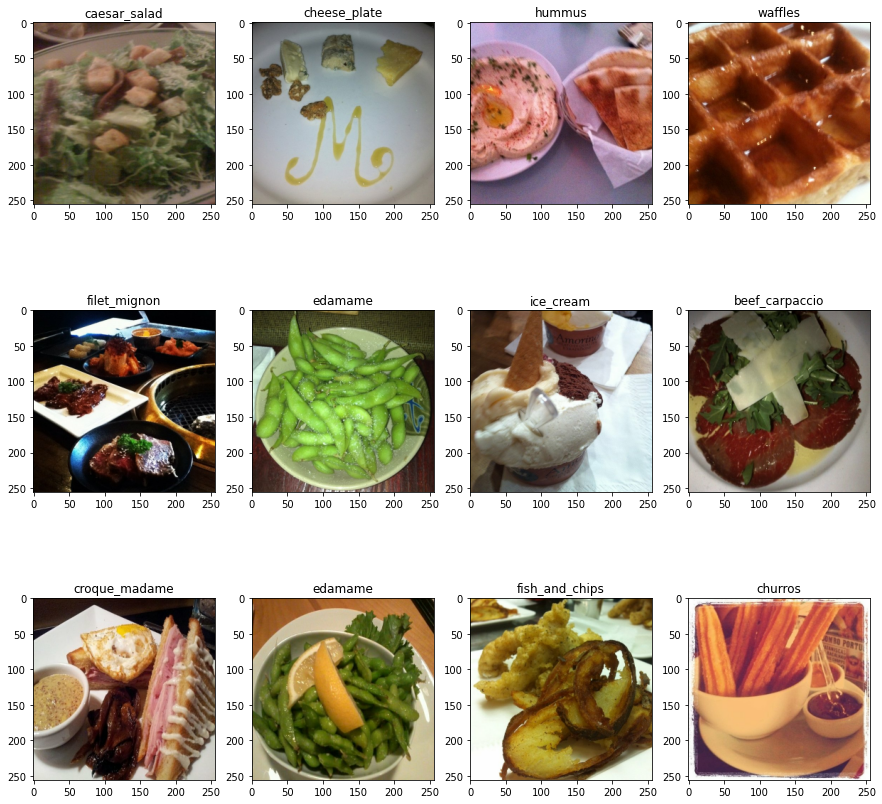

In [ ]:
# preview some images of random classes
plt.figure(figsize = (15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        a = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(food[label_batch[i]])
        plt.axis('on')

#### The images are of different sizes and aspect ratio, with at least one side of 512 pixels.

# Data Augmentation

#### In order to avoid overfitting problem and to expand the dataset. Image data generator from Keras is used for image tranformation.

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) #rescale to [0-1], add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory(
        "content/drive/MyDrive/food-101/food-101/images",
        target_size=(256,256),
        batch_size=32)
test_datagen = ImageDataGenerator(rescale=1/255) # just rescale to [0-1] for testing set
test_generator = test_datagen.flow_from_directory(
        "content/drive/MyDrive/food-101/food-101/images",
        target_size=(256,256),
        batch_size=32)

Found 101000 images belonging to 101 classes.
Found 101000 images belonging to 101 classes.


#### Just to make sure the image generator is working and the transformation is acceptable.

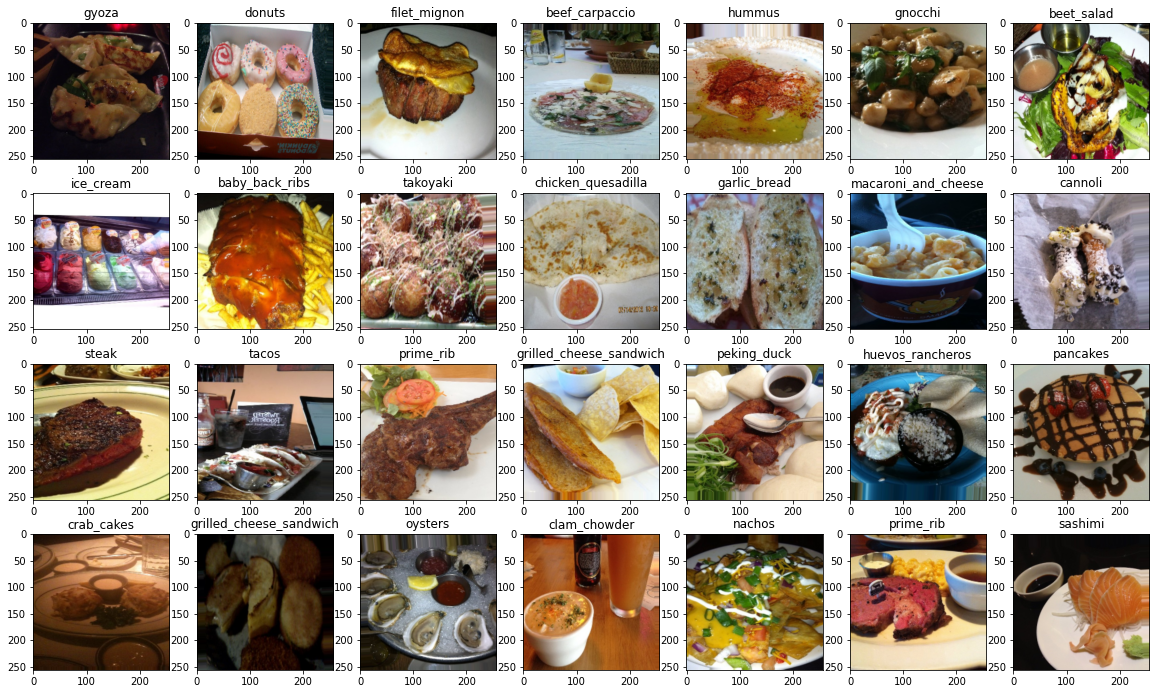

In [ ]:
# preview images from train generator
r = 4; c = 7
n=0
classtolabel = {}
for i in range(len(food)):
    classtolabel[str(i)] = str(food[i])
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

# Modelling

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (256,256,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(len(food), activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

#callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 32)        25632     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 64)        36928     
                                                      

In [ ]:
history = model.fit(
    train_generator,
    epochs = 75,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = test_generator,
    callbacks=[checkpointer, reduceLR, earlystopping],
    steps_per_epoch=len(dataset)//16,
    validation_steps=len(dataset)//16)

Epoch 1/75
197/197 [==============================] - ETA: 0s - loss: 4.7698 - accuracy: 0.0081
Epoch 1: val_loss improved from inf to 4.64819, saving model to model.hdf5
197/197 [==============================] - 293s 1s/step - loss: 4.7698 - accuracy: 0.0081 - val_loss: 4.6482 - val_accuracy: 0.0068 - lr: 0.0010
Epoch 2/75
197/197 [==============================] - ETA: 0s - loss: 4.6299 - accuracy: 0.0100
Epoch 2: val_loss improved from 4.64819 to 4.62003, saving model to model.hdf5
197/197 [==============================] - 266s 1s/step - loss: 4.6299 - accuracy: 0.0100 - val_loss: 4.6200 - val_accuracy: 0.0117 - lr: 0.0010
Epoch 3/75
197/197 [==============================] - ETA: 0s - loss: 4.6184 - accuracy: 0.0089
Epoch 3: val_loss improved from 4.62003 to 4.61651, saving model to model.hdf5
197/197 [==============================] - 261s 1s/step - loss: 4.6184 - accuracy: 0.0089 - val_loss: 4.6165 - val_accuracy: 0.0111 - lr: 0.0010
Epoch 4/75
197/197 [========================

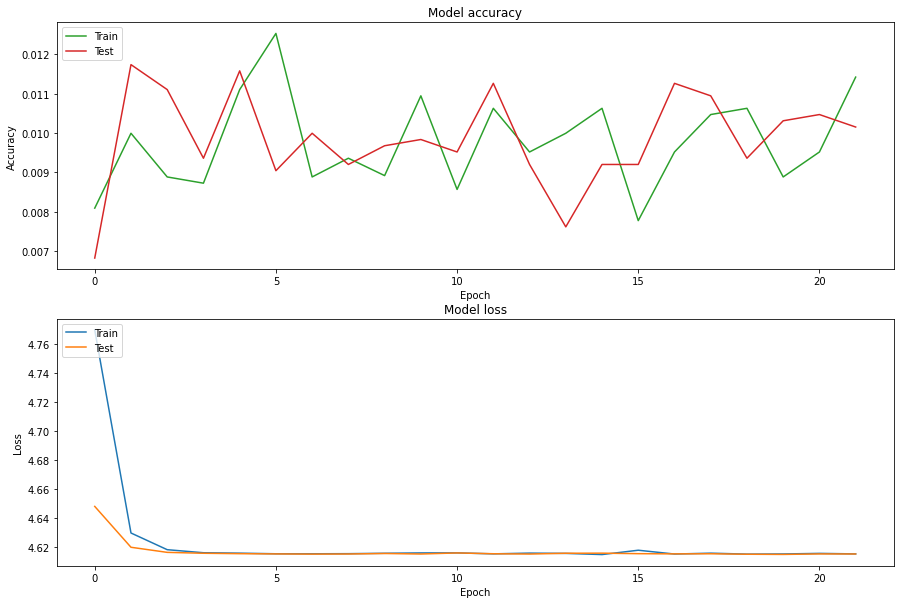

In [ ]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

# Evaluate results

In [ ]:
# create another generator for all test images in a single batch 
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
        "content/drive/MyDrive/food-101/food-101/images",
        target_size=(256,256),
        batch_size=750)

Found 101000 images belonging to 101 classes.


In [ ]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.2f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 0.67%


### Randomly check 5 predictions

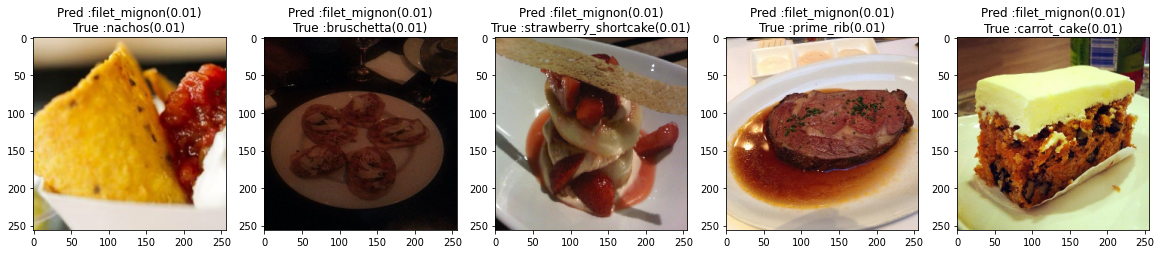

In [ ]:
ind = np.random.randint(1,len(x_test),5)
f, ax=plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    ax[i].imshow(x_test[j])
    ax[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                           classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))


### Confusion Matrix

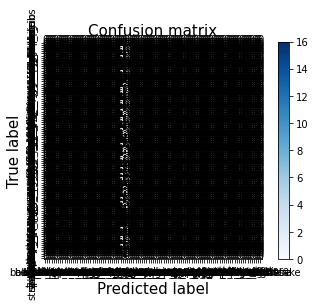

In [ ]:
def plot_confusion_matrix(cm,gd):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = gd
    plt.xticks([i for i in range(len(classes))], classes, fontsize=10)
    plt.yticks([i for i in range(len(classes))], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred),food)

### Inspect the predictions with wrong labels

In [ ]:
# find the wrong-est label (largest confidence wrong label)
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 5
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                                      (classtolabel[pred_errors[error].astype('str')],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error].astype('str')],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

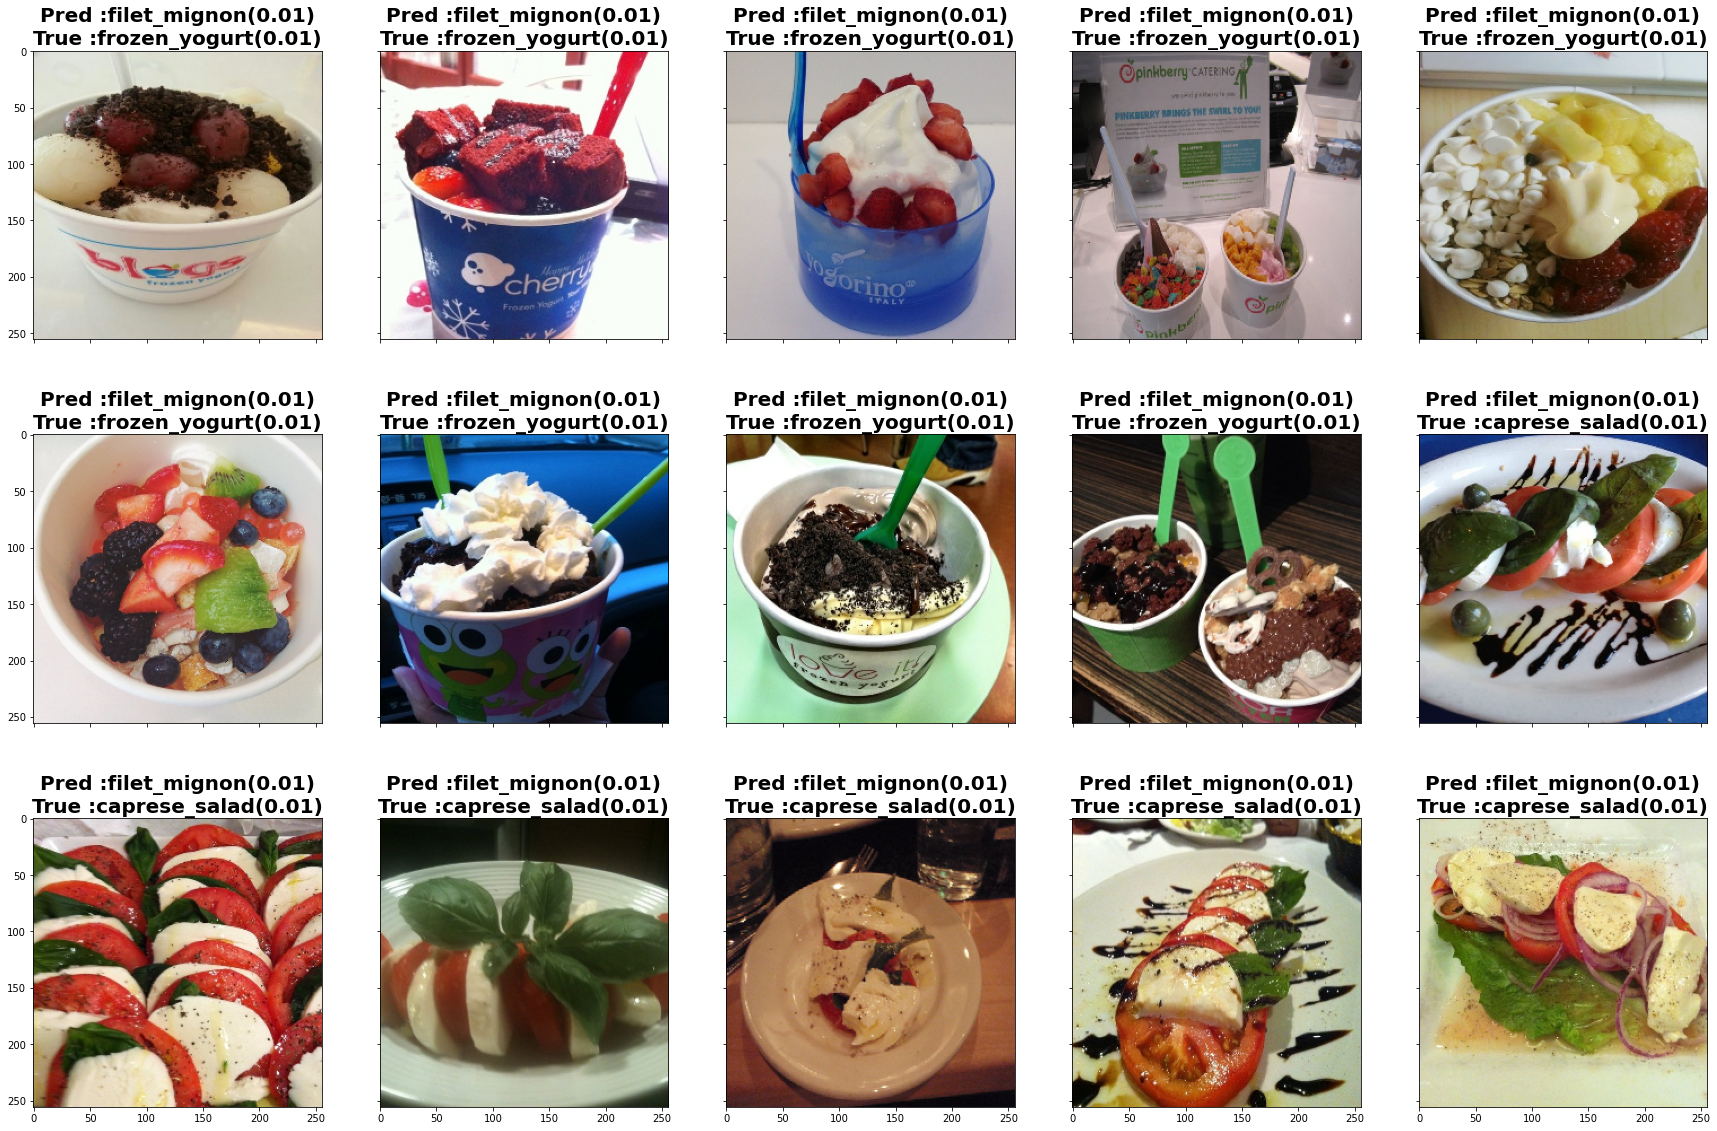

In [ ]:
show_wrongest_label(x_test,y_test,y_pred_conf)